# Demonstration of Tehom's capabilities

This notebook shows how to display downloaded data and sample it as machine learning
training data.  It requires some AIS and acoustic data be downloaded prior to running.
Prior to running this notebook, take the following steps:
1. Create [Ocean Networks Canada account](https://data.oceannetworks.ca/Login?service=https://data.oceannetworks.ca/LandingPage)
and get your API token [here](https://data.oceannetworks.ca/Profile#api_tab>)
1. Run `tehom.downloads.save_user_token(<your token>)`
1. Run ```tehom.downloads.download_ais_data(2016, 6, 9)```
1. Run 

In [1]:
import pandas as pd

import tehom.downloads as td

## Identifying data
This section describes how to interrogate which acoustic data is available for download
and which ship label/acoustic data have already been downloaded and are ready for
sampling.
By assumption, all months of AIS (ship label) data are available to download.  However, 
ONC (acoustic) data is only available during certain periods, varying by hydrophone.  

This section is divided into functions that return code objects (lists, DataFrames, etc)
and the graphical `show_data()` function.
### Code objects
The `get_ais_downloads()` function returns a list of AIS downloads. Each record is a
tuple of (year, month, [UTM zone](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)).
Most ONC data is available in UTM zones 9 and 10

In [4]:
td.get_ais_downloads()

[(2016, 6, 9), (2016, 6, 10)]

The `get_audio_availability()` function lists the hydophone deployments as a pandas
DataFrame.  
Important columns are 
* `deviceCode` (hydrophone name)
* `begin` (when hydrophone was deployed)
* `end` (when hydrophone was removed/relocated)
* `lat` (latitude)
* `lon` (longitude)


In [5]:
td.get_audio_availability()

Requesting URL:
https://data.oceannetworks.ca/api/deployments?deviceCategoryCode=HYDROPHONE&method=get&token=f32ee0a7-1824-4e49-b695-35d723419d3b
Web Service response time: 2 seconds


,begin,depth,deviceCategoryCode,deviceCode,end,hasDeviceData,heading,lat,locationCode,lon,pitch,roll,zone
1,2009-09-11 00:27:51+00:00,982.4,HYDROPHONE,NAXYS_HYD_007,2010-05-16 13:49:01+00:00,True,NaN,48.316732,BACAX,-126.050142,NaN,NaN,9
2,2010-05-17 17:33:14+00:00,981.0,HYDROPHONE,NAXYS_HYD_007,2011-07-14 06:28:04+00:00,True,NaN,48.316758,BACAX,-126.050183,NaN,NaN,9
3,2018-06-22 03:05:27+00:00,647.0,HYDROPHONE,ICLISTENHF1252,2019-09-17 01:11:56+00:00,True,NaN,48.345900,BACND,-126.157938,NaN,NaN,9
4,2019-09-17 01:11:56+00:00,643.0,HYDROPHONE,ICLISTENHF1252,2020-06-01 21:37:15+00:00,True,NaN,48.345773,BACND,-126.157685,NaN,NaN,9
10,2016-06-16 05:18:32+00:00,394.0,HYDROPHONE,ICLISTENHF1251,2018-07-01 01:48:20+00:00,True,NaN,48.426393,BACUS.H1,-126.174394,NaN,NaN,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,2011-07-03 15:00:00+00:00,170.0,HYDROPHONE,IOS3HYDARR03,2011-12-11 23:30:00+00:00,True,NaN,49.000000,SGE.H1,-123.000000,NaN,NaN,10
168,2011-12-11 21:00:00+00:00,170.0,HYDROPHONE,ICHYDROPHONE203,2012-08-09 21:00:00+00:00,True,NaN,49.042422,SGE.H2,-123.317143,NaN,NaN,10
169,2021-03-25 16:52:01+00:00,110.0,HYDROPHONE,ICLISTENAF2556,2021-09-08 20:58:15+00:00,True,NaN,49.084384,USDDL,-123.330335,NaN,NaN,10
170,2022-03-11 20:42:58+00:00,112.0,HYDROPHONE,ICLISTENAF2556,2022-09-26 00:04:19+00:00,True,NaN,49.084282,USDDL,-123.330795,NaN,NaN,10


Acoustic recordings are not available during all deployments and intermittently
available in others.  To discover periods with contiguous acoustic data, tehom would
have to:
1. Query the ONC server for a list of all acoustic files
2. Download them
3. open the files to read the length
4. concatenate all the intervals appropriately.
Rather than do steps 2 and 3, tehom assumes all files are 5 min long (300 sec).  This is
usually true, but in odd cases causes wrong intervals.  We call this process
"certifying" data availability.  Despite skipping steps 2 and 3, the process still takes
a long time, so the funciton `certify_audio_availability()` stores the result locally,
saving progress in a pickle along the way.  This allows you to interrupt the function
and resume it later.


Note: When downloading acoustic files during an interval, it is not necessary to choose
exact times to bookend the data.  ONC servers find the correct files in a given
interval, so deployment intervals and certified intervals are just guides for users.


Uncomment, run, and then stop the following cell after a certain amount of time has
passed:

In [4]:
# td.certify_audio_availability()

Inspect the certified list to see what deployments have been fully certified:

In [6]:
from tehom import _persistence
_persistence.load_audio_availability_progress().tail()

,deviceCode,begin,depth,deviceCategoryCode,end,hasDeviceData,heading,lat,locationCode,lon,pitch,roll,zone
167,IOS3HYDARR03,2011-07-03 15:00:00+00:00,170.0,HYDROPHONE,2011-12-11 23:30:00+00:00,True,NaN,49.0,SGE.H1,-123.0,NaN,NaN,10
168,ICHYDROPHONE203,2011-12-11 21:00:00+00:00,170.0,HYDROPHONE,2012-08-09 21:00:00+00:00,True,NaN,49.042422,SGE.H2,-123.317143,NaN,NaN,10
169,ICLISTENAF2556,2021-03-25 16:52:01+00:00,110.0,HYDROPHONE,2021-09-08 20:58:15+00:00,True,NaN,49.084384,USDDL,-123.330335,NaN,NaN,10
170,ICLISTENAF2556,2022-03-11 20:42:58+00:00,112.0,HYDROPHONE,2022-09-26 00:04:19+00:00,True,NaN,49.084282,USDDL,-123.330795,NaN,NaN,10
171,ICLISTENAF2556,2018-10-04 19:28:01+00:00,105.0,HYDROPHONE,2020-03-06 20:10:00+00:00,True,NaN,49.085321,USSLP,-123.329648,NaN,NaN,10


Inspect the database for the calculated continuous data intervals.
There are a lot, because gaps of only a few milliseconds count as an interruption.
`tehom.downloads.OVERLAP_PRECISION` may be changed in future without deprecation.

In [7]:
certified = td.get_audio_availability(certified=True)
certified.tail()

,deviceCode,begin,end,lat,lon,zone
493233,ICLISTENAF2556,2019-12-22 08:38:03+00:00,2019-12-22 15:38:01+00:00,49.085321,-123.329648,10
493234,ICLISTENAF2556,2019-12-22 15:38:02+00:00,2019-12-22 16:38:02+00:00,49.085321,-123.329648,10
493235,ICLISTENAF2556,2019-12-22 16:38:03+00:00,2019-12-22 18:38:02+00:00,49.085321,-123.329648,10
493236,ICLISTENAF2556,2019-12-22 18:38:03+00:00,2019-12-22 20:38:02+00:00,49.085321,-123.329648,10
493237,ICLISTENAF2556,2019-12-22 20:38:03+00:00,2019-12-22 20:58:01+00:00,49.085321,-123.329648,10


### How to `show_data()` in plots
Instead of using code objects, tehom provides a graphical tool to display available data
for EDA in either a bar chart or surface map

Bar chart shows the AIS downloaded data (orange), acoustic data avilable for download
(blue), mp3 data downloaded (green), and wav data downloaded (red):

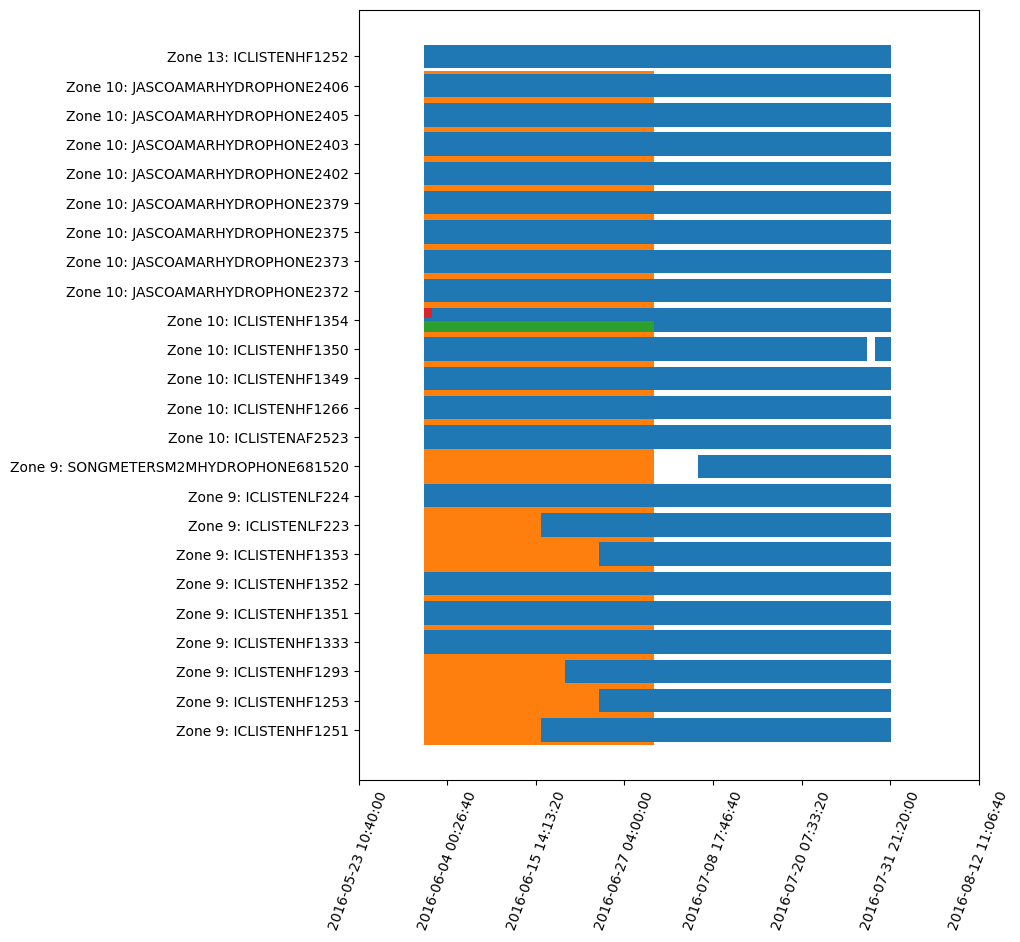

In [4]:
fig = td.show_available_data(begin="2016-06", end="2016-08", style="bar")
fig.show()

Now let's look at intervals for which we've certified the data availability (takes a lot
longer because every small data gap results in another bar to draw):

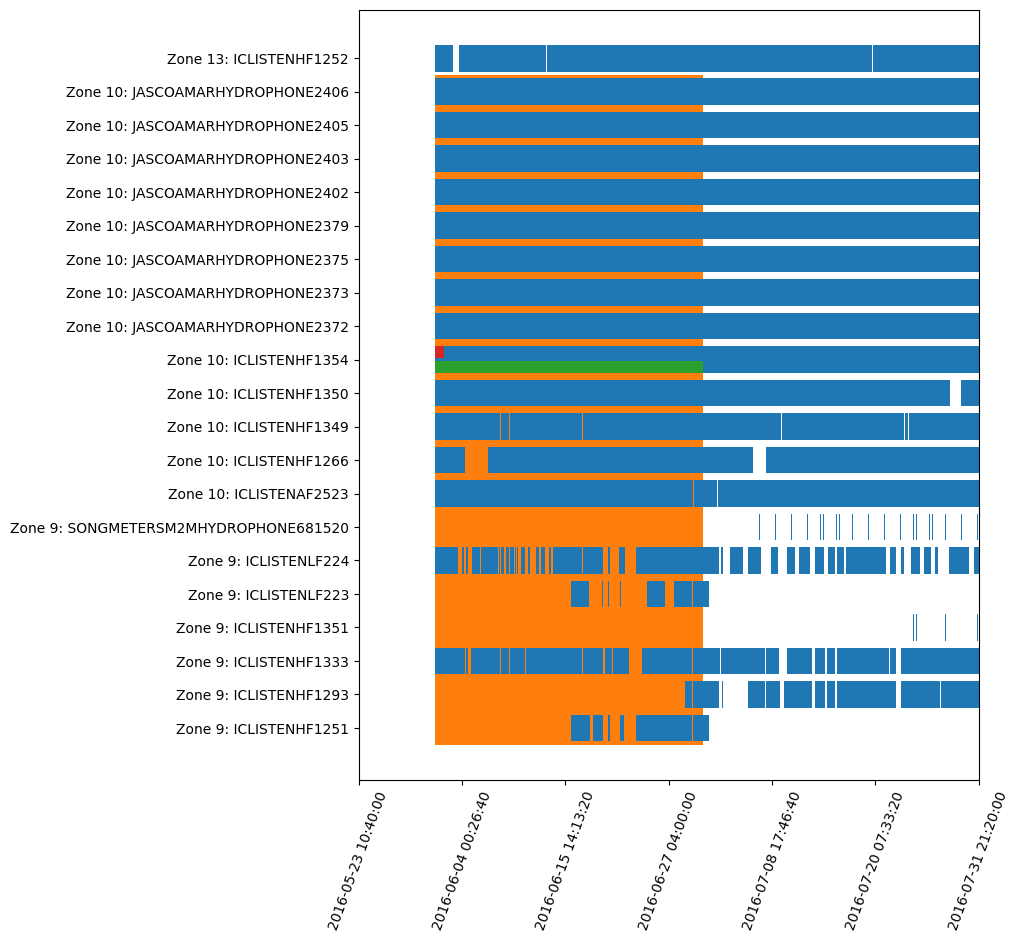

In [5]:
fig = td.show_available_data(begin="2016-06", end="2016-08", style="bar", certified=True)
fig.show()

Map:

In [7]:
fig = td.show_available_data(begin="2016-06", end="2016-08", style="map")
fig.show()